In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping

In [2]:
IMAGE_SIZE_X=600
IMAGE_SIZE_Y=256
BATCH_SIZE=32
CHHANELS=3
EPOCHS=100

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Medicinal plant dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE_X,IMAGE_SIZE_Y),
    batch_size=BATCH_SIZE

)

Found 5945 files belonging to 40 classes.


In [4]:
class_name=dataset.class_names
class_name

['Aloevera',
 'Amla',
 'Amruta_Balli',
 'Arali',
 'Ashoka',
 'Ashwagandha',
 'Avacado',
 'Bamboo',
 'Basale',
 'Betel',
 'Betel_Nut',
 'Brahmi',
 'Castor',
 'Curry_Leaf',
 'Doddapatre',
 'Ekka',
 'Ganike',
 'Gauva',
 'Geranium',
 'Henna',
 'Hibiscus',
 'Honge',
 'Insulin',
 'Jasmine',
 'Lemon',
 'Lemon_grass',
 'Mango',
 'Mint',
 'Nagadali',
 'Neem',
 'Nithyapushpa',
 'Nooni',
 'Pappaya',
 'Pepper',
 'Pomegranate',
 'Raktachandini',
 'Rose',
 'Sapota',
 'Tulasi',
 'Wood_sorel']

In [5]:
len(dataset)

186

In [6]:
186*32

5952

In [7]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    print(label_batch)
    

(32, 600, 256, 3)
[28 18 34  5 29 11  4 14 34 11 13 36  4 17  9 34 36 37 14  2  3 29 13 38
 29 31 31  1 37 11 18  3]
tf.Tensor(
[28 18 34  5 29 11  4 14 34 11 13 36  4 17  9 34 36 37 14  2  3 29 13 38
 29 31 31  1 37 11 18  3], shape=(32,), dtype=int32)


In [8]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[155.32812  127.328125 106.328125]
  [152.98438  124.984375 103.984375]
  [150.64062  122.640625 101.28125 ]
  ...
  [125.5625   108.5625    90.5625  ]
  [132.96875  115.96875   97.96875 ]
  [134.       117.        99.      ]]

 [[150.12305  122.12305  101.12305 ]
  [148.61914  120.61914   99.61914 ]
  [147.74023  119.740234  98.38086 ]
  ...
  [126.1875   109.1875    91.1875  ]
  [133.58398  116.583984  98.583984]
  [134.       117.        99.      ]]

 [[144.75     117.125     96.125   ]
  [144.13086  116.50586   95.50586 ]
  [144.63477  117.14453   95.65039 ]
  ...
  [127.3125   109.5625    91.9375  ]
  [133.96484  116.21484   98.58984 ]
  [133.87695  116.12695   98.50195 ]]

 ...

 [[119.109375 104.359375  87.609375]
  [117.822266 102.44141   86.97266 ]
  [127.71875  112.19336   99.41211 ]
  ...
  [196.91602  160.38477  125.      ]
  [197.22852  160.00977  124.75391 ]
  [195.71484  159.1211   123.74805 ]]

 [[118.359375 100.609375  84.984375]
  [117.453125  99.072266  85.109375]


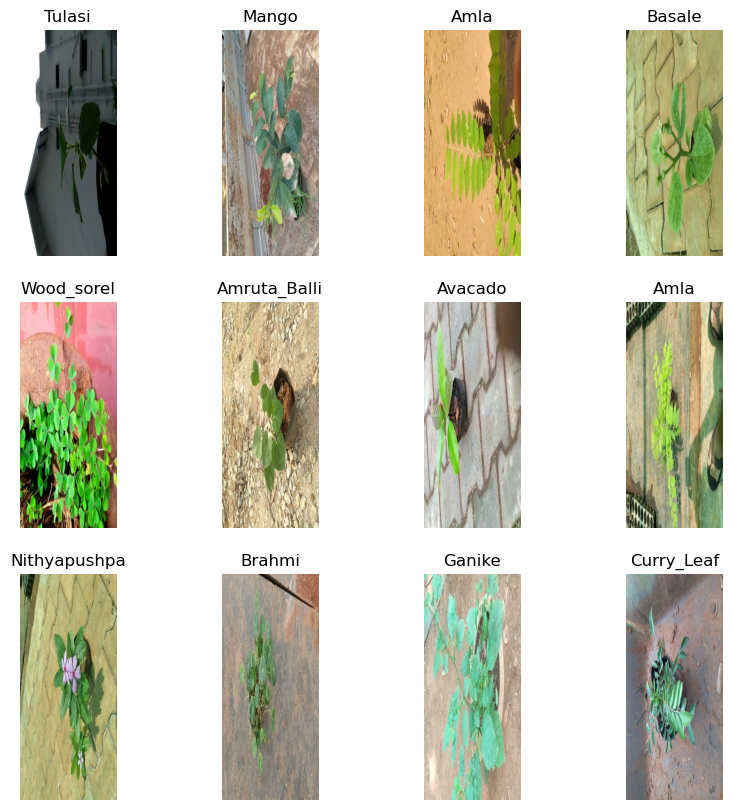

In [9]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")


In [10]:
len(dataset)

186

80% ==> training <br>
20% ==> validation ,10% test

In [11]:
train_size=0.8
len(dataset)*train_size

148.8

In [12]:
train_ds=dataset.take(148)
len(train_ds)

148

In [13]:
test_ds_t=dataset.skip(148)
len(test_ds_t)

38

In [14]:
val_size=0.1
len(dataset)*val_size

18.6

In [15]:
val_ds=test_ds_t.take(18)
len(val_ds)

18

In [16]:
test_ds=test_ds_t.skip(18)
len(test_ds)

20

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

148

In [20]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE_X,IMAGE_SIZE_Y),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [22]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [38]:
input_shape = (BATCH_SIZE, IMAGE_SIZE_X, IMAGE_SIZE_Y, CHHANELS)
n_classes = 40

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (2, 2), activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    
    
    
    
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [39]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 600, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 600, 256, 3)       0         
                                                                 
 conv2d_87 (Conv2D)          (32, 598, 254, 32)        896       
                                                                 
 dropout_51 (Dropout)        (32, 598, 254, 32)        0         
                                                                 
 batch_normalization_45 (Ba  (32, 598, 254, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_79 (MaxPooli  (32, 299, 127, 32)        0         
 ng2D)                                               

In [40]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [41]:
for x,y in train_ds.take(1):
    print(type(x))
    print(y)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\High-Tech\AppData\Local\Temp\ipykernel_11604\604494893.py", line 1, in <module>
    for x,y in train_ds.take(1):
  File "C:\Users\High-Tech\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\data\ops\iterator_ops.py", line 814, in __next__
    return self._next_internal()
  File "C:\Users\High-Tech\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\data\ops\iterator_ops.py", line 777, in _next_internal
    ret = gen_dataset_ops.iterator_get_next(
  File "C:\Users\High-Tech\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\ops\gen_dataset_ops.py", line 3055, in iterator_get_next
    _ops.raise_from_not_ok_status(e, name)
  File "C:\Users\High-Tech\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\framework\ops.py", lin

In [ ]:
callback=EarlyStopping(
monitor='val_loss',
min_delta=0.0001,
patience=5,
verbose=1,
mode='auto',
baseline=None,
restore_best_weights=False
)

In [27]:
history=model.fit(
    train_ds,
    epochs=100,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=callback,
    
)

Epoch 1/10
148/148 [==============================] - 733s 4s/step - loss: 3.6616 - accuracy: 0.0334 - val_loss: 3.5634 - val_accuracy: 0.0382
Epoch 2/10
148/148 [==============================] - 466s 3s/step - loss: 3.4413 - accuracy: 0.0630 - val_loss: 3.2267 - val_accuracy: 0.0920
Epoch 3/10
148/148 [==============================] - 554s 4s/step - loss: 3.1477 - accuracy: 0.1104 - val_loss: 2.9892 - val_accuracy: 0.1285
Epoch 4/10
148/148 [==============================] - 559s 4s/step - loss: 2.9048 - accuracy: 0.1643 - val_loss: 2.8457 - val_accuracy: 0.1823
Epoch 5/10
148/148 [==============================] - 557s 4s/step - loss: 2.8086 - accuracy: 0.1956 - val_loss: 2.7114 - val_accuracy: 0.1927
Epoch 6/10
148/148 [==============================] - 542s 4s/step - loss: 2.6977 - accuracy: 0.2195 - val_loss: 2.5136 - val_accuracy: 0.2604
Epoch 7/10
148/148 [==============================] - 2026s 14s/step - loss: 2.4930 - accuracy: 0.2717 - val_loss: 2.3948 - val_accuracy: 0.27

In [29]:
scores=model.evaluate(test_ds)

20/20 [==============================] - 20s 952ms/step - loss: 2.1303 - accuracy: 0.3594


In [30]:
scores

[2.1303348541259766, 0.359375]

In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 148}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
type(history.history['loss'])

list

In [36]:
len(history.history['loss'])

10

In [37]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

In [41]:
EPOCHS

50

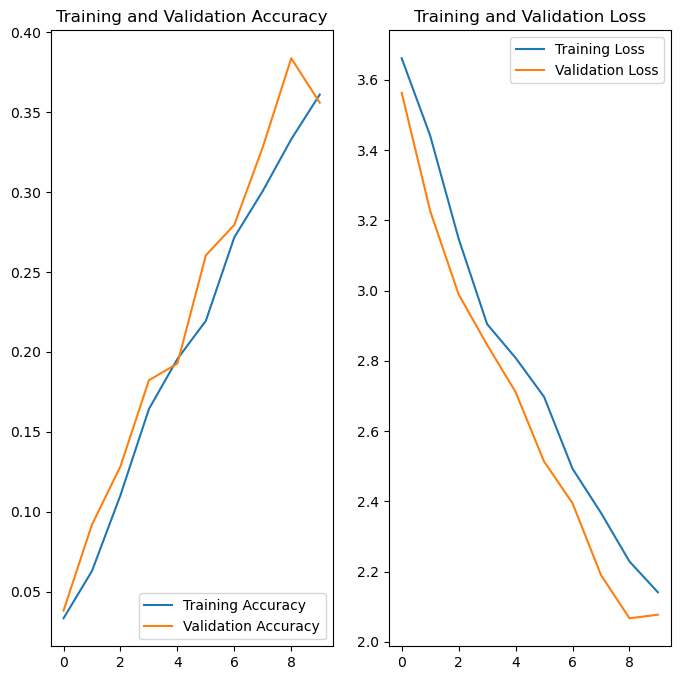

In [44]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label : Mint
1/1 [==============================] - 3s 3s/step
(32, 40)
predicted label: Mint


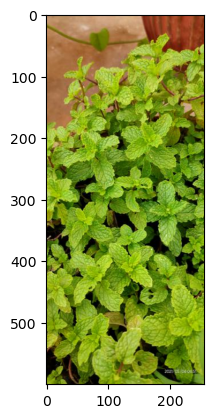

In [83]:
for image_batch,label_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint')
    first_label=label_batch[0]
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label :",class_name[first_label])
    
    batch_prediction=model.predict(image_batch)
    print(batch_prediction.shape)
    print("predicted label:" ,class_name[np.argmax(batch_prediction[0])])
    

In [85]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
    
    predicted_class=class_name[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])) ,2)
    return predicted_class,confidence

1/1 [==============================] - 0s 52ms/step


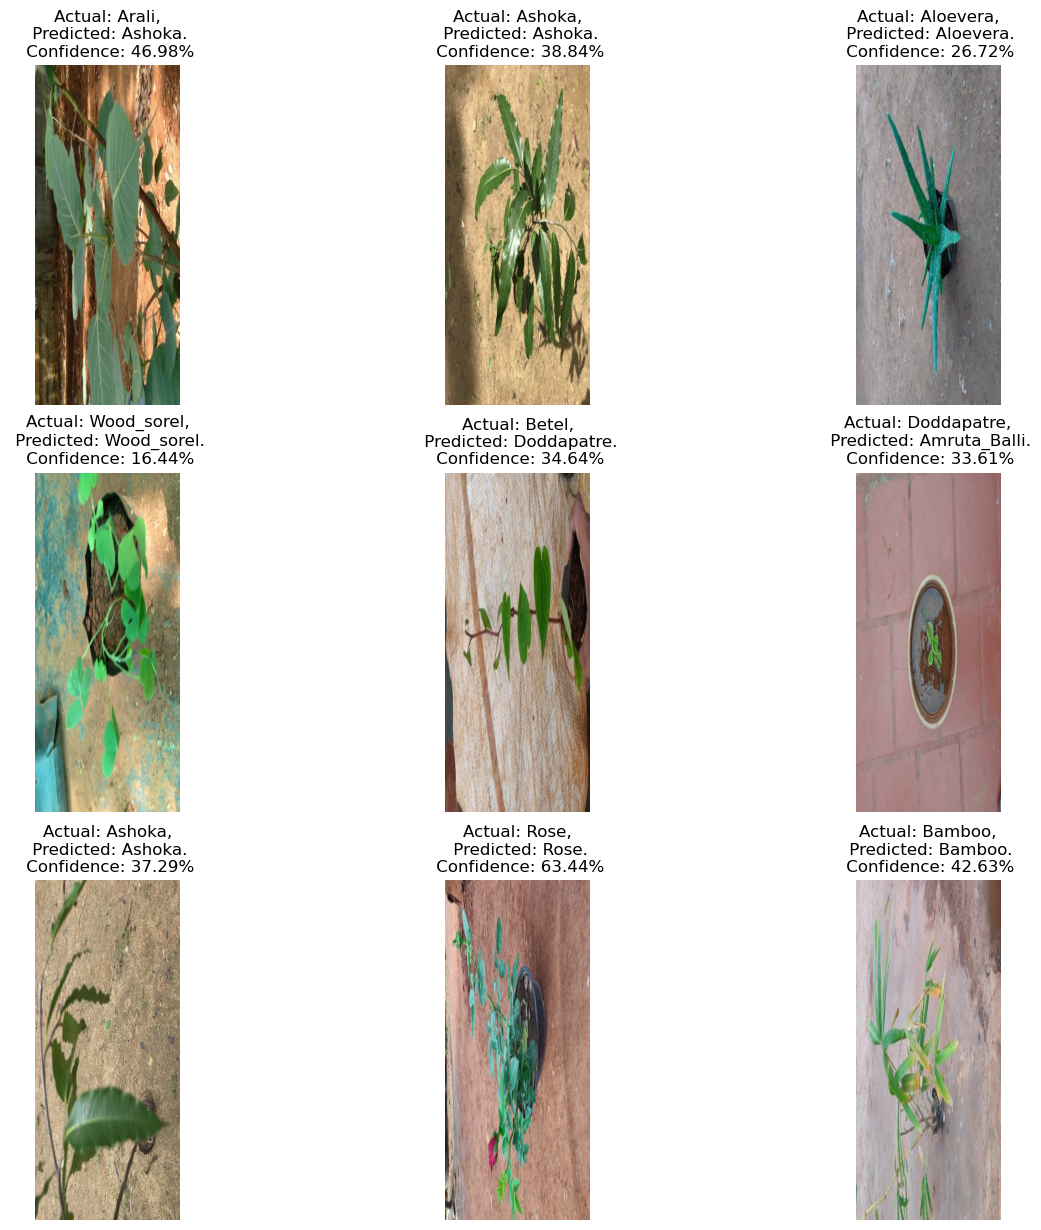

In [87]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [89]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
